In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from damped_newton import damped_newton, damped_newton_linesearch
from PMF import pmf_matrix_completion
from alternating_least_squares import als

In [4]:
# Here we select first 500 images and convert them to grayscale format
# I also added resize method, since some of the images a little bit bigger and it seems to be more convenient to use images of the same size

input_folder = "img_align_celeba"
output_folder = "celeba_grayscale"  # Folder to save grayscale images

# Create output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all images in the input folder
for filename in sorted(os.listdir(input_folder))[:500]:
    if filename.endswith(".jpg"):  # CelebA images are in JPG format
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        # Convert to grayscale
        grayscale_image = image.convert("L")
        grayscale_image = grayscale_image.resize((128, 128), Image.Resampling.LANCZOS)

        # Save the grayscale image
        output_path = os.path.join(output_folder, filename)
        grayscale_image.save(output_path)

        print(f"Processed: {filename}")

print("All images converted to grayscale!")

Processed: 000001.jpg
Processed: 000002.jpg
Processed: 000003.jpg
Processed: 000004.jpg
Processed: 000005.jpg
Processed: 000006.jpg
Processed: 000007.jpg
Processed: 000008.jpg
Processed: 000009.jpg
Processed: 000010.jpg
Processed: 000011.jpg
Processed: 000012.jpg
Processed: 000013.jpg
Processed: 000014.jpg
Processed: 000015.jpg
Processed: 000016.jpg
Processed: 000017.jpg
Processed: 000018.jpg
Processed: 000019.jpg
Processed: 000020.jpg
Processed: 000021.jpg
Processed: 000022.jpg
Processed: 000023.jpg
Processed: 000024.jpg
Processed: 000025.jpg
Processed: 000026.jpg
Processed: 000027.jpg
Processed: 000028.jpg
Processed: 000029.jpg
Processed: 000030.jpg
Processed: 000031.jpg
Processed: 000032.jpg
Processed: 000033.jpg
Processed: 000034.jpg
Processed: 000035.jpg
Processed: 000036.jpg
Processed: 000037.jpg
Processed: 000038.jpg
Processed: 000039.jpg
Processed: 000040.jpg
Processed: 000041.jpg
Processed: 000042.jpg
Processed: 000043.jpg
Processed: 000044.jpg
Processed: 000045.jpg
Processed:

In [5]:
# Here we convert grayscale images to the arrays
image_folder = "celeba_grayscale"  # Folder containing grayscale images
# Parameters
image_size = (128, 128)  # Desired image size

# Load and preprocess images
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
num_images = len(image_files)
images = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path)

    # Convert to NumPy array and normalize pixel values to [0, 1]
    image_array = np.array(image) / 255.0
    images.append(image_array)

    print(f"Processed: {filename}")

# Convert list of images to a NumPy array
images = np.array(images)
print(f"Loaded {num_images} images of shape {images[0].shape}.")

Processed: 000152.jpg
Processed: 000146.jpg
Processed: 000191.jpg
Processed: 000185.jpg
Processed: 000378.jpg
Processed: 000350.jpg
Processed: 000436.jpg
Processed: 000422.jpg
Processed: 000344.jpg
Processed: 000393.jpg
Processed: 000387.jpg
Processed: 000218.jpg
Processed: 000224.jpg
Processed: 000230.jpg
Processed: 000026.jpg
Processed: 000032.jpg
Processed: 000033.jpg
Processed: 000027.jpg
Processed: 000231.jpg
Processed: 000225.jpg
Processed: 000219.jpg
Processed: 000386.jpg
Processed: 000392.jpg
Processed: 000423.jpg
Processed: 000345.jpg
Processed: 000351.jpg
Processed: 000437.jpg
Processed: 000379.jpg
Processed: 000184.jpg
Processed: 000190.jpg
Processed: 000147.jpg
Processed: 000153.jpg
Processed: 000179.jpg
Processed: 000145.jpg
Processed: 000151.jpg
Processed: 000186.jpg
Processed: 000192.jpg
Processed: 000409.jpg
Processed: 000347.jpg
Processed: 000421.jpg
Processed: 000435.jpg
Processed: 000353.jpg
Processed: 000384.jpg
Processed: 000390.jpg
Processed: 000233.jpg
Processed:

In [6]:
# Simple random masking with sparsity_level as a parameter
def mask_entries(image, sparsity_level=0.3,fill_value=0.0):
    mask = np.random.rand(*image.shape) < sparsity_level
    masked_image = image.copy()
    masked_image[mask] = fill_value
    return masked_image, mask

def calculate_mse(original, predicted, mask=True):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    return mse

def calculate_psnr(original, predicted, mask=True, max_pixel=1.0):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


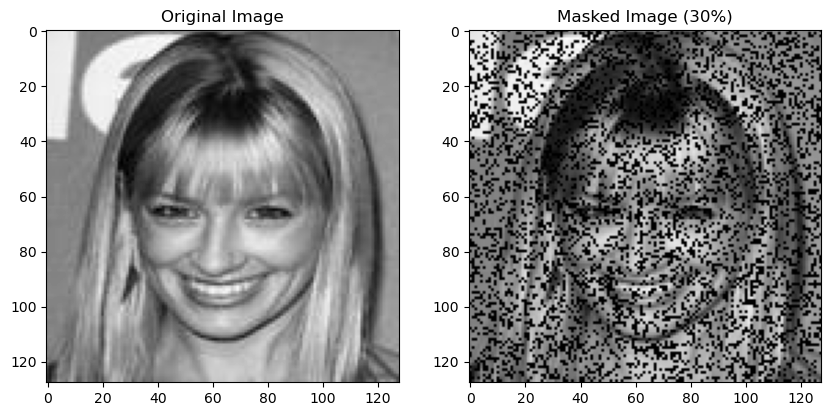

In [7]:
# Kinda scary example
masked_image, mask = mask_entries(images[2])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[2], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Masked Image (30%)")
plt.imshow(masked_image, cmap="gray")
plt.show()

In [8]:
# simple SVD example to see what results we can expect

# SGD
image_SGD = images[2]
m, n = image_SGD.shape

masked_image_SGD, mask = mask_entries(image_SGD, sparsity_level=0.3)

k = 50  # Number of latent factors
U = np.random.normal(scale=1.0/k, size=(m, k))
V = np.random.normal(scale=1.0/k, size=(n, k))
learning_rate = 0.01
regularization = 0.1
num_epochs = 300

observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

for epoch in range(num_epochs):
    np.random.shuffle(observed_pixels)  # Shuffle observed pixels
    total_error = 0
    for i, j in observed_pixels:
        error = image_SGD[i, j] - np.dot(U[i, :], V[j, :].T)
        U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])
        V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])
        total_error += error**2

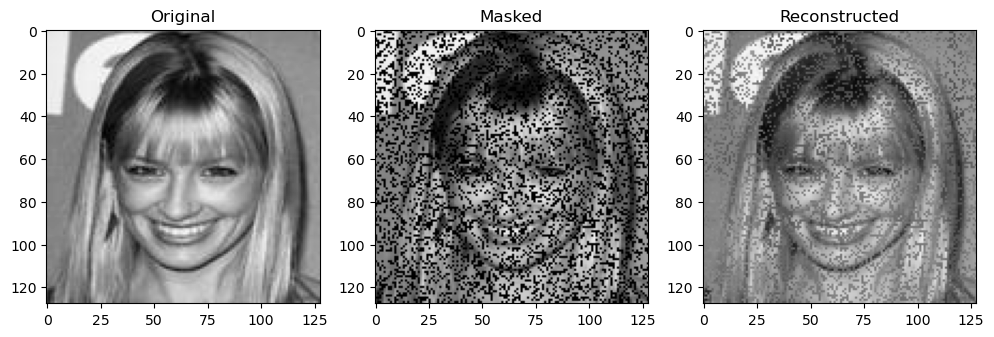

0.01109399843299088
19.549118998005635


In [9]:
#SGD
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_SGD, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_SGD, cmap='gray')
plt.title("Masked")

reconstructed_image_SGD = np.dot(U, V.T)
final_image = image_SGD.copy()
final_image[mask] = reconstructed_image_SGD[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_SGD = calculate_mse(image_SGD,final_image,True)
psnr_SGD=calculate_psnr(image_SGD,final_image,True,max_pixel=1.0)
print(mse_SGD)
print(psnr_SGD)

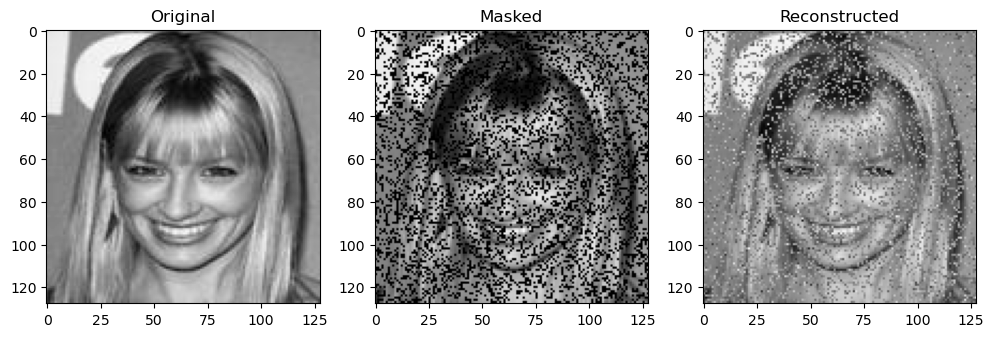

0.015428767103112702
18.11668776575062


In [10]:
#PMF
image_PMF = images[2]
m, n = image_PMF.shape
masked_image_PMF, mask = mask_entries(image_PMF, sparsity_level=0.3)

U, V = pmf_matrix_completion(image_PMF, mask)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_PMF, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_PMF, cmap='gray')
plt.title("Masked")

reconstructed_image_PMF = np.dot(U, V.T)
reconstructed_image_PMF -= reconstructed_image_PMF.min()
reconstructed_image_PMF /= reconstructed_image_PMF.max()

final_image_PMF = image_PMF.copy()
final_image_PMF[mask] = reconstructed_image_PMF[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_PMF, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_PMF = calculate_mse(image_PMF,final_image_PMF,True)
psnr_PMF=calculate_psnr(image_PMF,final_image_PMF,True,max_pixel=1.0)
print(mse_PMF)
print(psnr_PMF)

In [15]:
#Damped Newton
image_NT = images[2]
m, n = image_NT.shape
masked_image_NT, mask = mask_entries(image_NT, sparsity_level=0.3)
W = (masked_image_NT != 0.0).astype(float)
A,B = damped_newton(masked_image_NT,W,10)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NT, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NT, cmap='gray')
plt.title("Masked")

reconstructed_image_NT = np.dot(A, B.T)
final_image_NT = image_NT.copy()
final_image_NT[mask] = reconstructed_image_NT[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NT, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_NT = calculate_mse(image_NT,final_image_NT,True)
psnr_NT=calculate_psnr(image_NT,final_image_NT,True,max_pixel=1.0)
print(mse_NT)
print(psnr_NT)


KeyboardInterrupt: 

In [15]:
#Damped Newton with linesearch
image_NTls = images[2]
m, n = image_NTls.shape
masked_image_NTls, mask = mask_entries(image_NTls, sparsity_level=0.3)
W = (masked_image_NTls != 0.0).astype(float)
A,B = damped_newton_linesearch(masked_image_NTls,W,10)

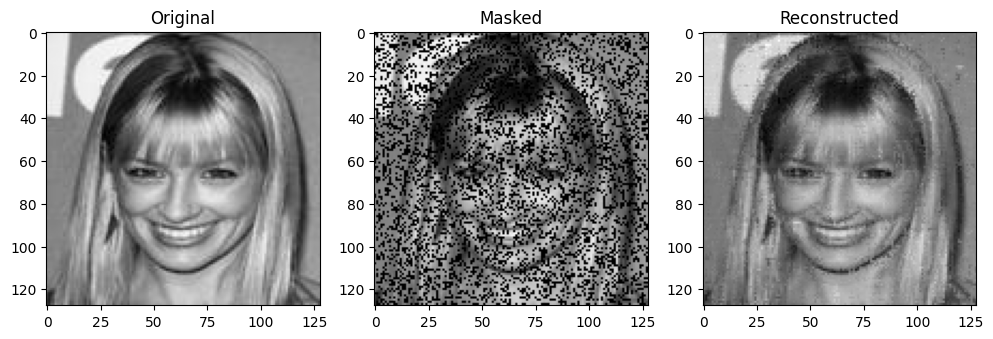

0.09224192316800565
10.350716509372763


In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NTls, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NTls, cmap='gray')
plt.title("Masked")

reconstructed_image_NTls = np.dot(A, B.T)
final_image_NTls = image_NTls.copy()
final_image_NTls[mask] = reconstructed_image_NTls[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NTls, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_NTls = calculate_mse(masked_image_NTls,final_image_NTls,True)
psnr_NTls = calculate_psnr(masked_image_NTls,final_image_NTls,True,max_pixel=1.0)
print(mse_NTls)
print(psnr_NTls)

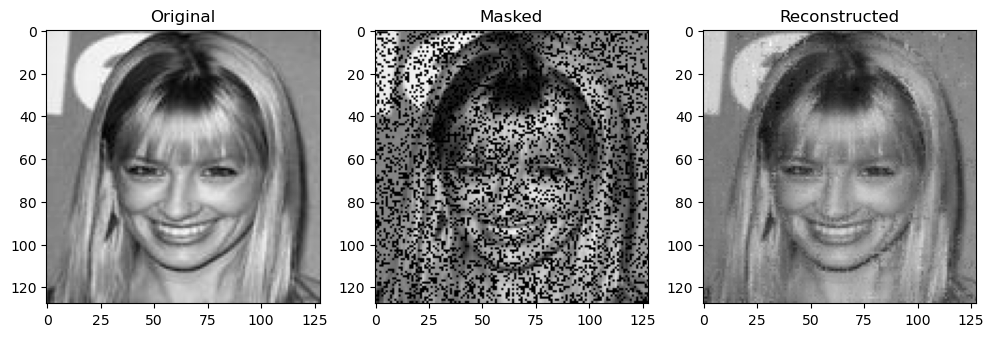

0.0017149763798799396
27.657418570547065


In [12]:
# ALS
image_ALS = images[2]
m, n = image_ALS.shape  
masked_image_ALS, mask = mask_entries(image_ALS, sparsity_level=0.3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_ALS, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_ALS, cmap='gray')
plt.title("Masked")

reconstructed_image_ALS = als(masked_image_ALS, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
final_image_ALS = image_ALS.copy()
final_image_ALS[mask] = reconstructed_image_ALS[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_ALS, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_ALS = calculate_mse(image_ALS,final_image_ALS,True)
psnr_ALS=calculate_psnr(image_ALS,final_image_ALS,True,max_pixel=1.0)
print(mse_ALS)
print(psnr_ALS)

In [13]:
sparsity_levels = np.linspace(0.1, 0.9, 9)
mse_sgd, psnr_sgd = [], []
mse_pmf, psnr_pmf = [], []
mse_ntls, psnr_ntls = [], []
mse_als, psnr_als = [], []

image_index = 2  # Pick one image for consistency
image = images[image_index]
m, n = image.shape


In [16]:
for s in sparsity_levels:
    masked_image, mask = mask_entries(image, sparsity_level=s)
    U = np.random.normal(scale=1.0/k, size=(m, k))
    V = np.random.normal(scale=1.0/k, size=(n, k))

    observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

    for epoch in range(num_epochs):
        np.random.shuffle(observed_pixels)
        for i, j in observed_pixels:
            error = image[i, j] - np.dot(U[i, :], V[j, :].T)
            U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])
            V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])

    reconstructed = np.dot(U, V.T)
    reconstructed -= reconstructed.min()
    reconstructed /= reconstructed.max()

    final_image = image.copy()
    final_image[mask] = reconstructed[mask]

    mse_sgd.append(calculate_mse(image, final_image, True))
    psnr_sgd.append(calculate_psnr(image, final_image, True))



In [17]:
for s in sparsity_levels:
    # Mask the image based on the current sparsity level
    masked_image, mask = mask_entries(image, sparsity_level=s)

    # Apply PMF matrix completion
    U, V = pmf_matrix_completion(masked_image, mask)

    # Reconstruct the image
    reconstructed_image = np.dot(U, V.T)
    reconstructed_image -= reconstructed_image.min()  # Normalize to [0, 1]
    reconstructed_image /= reconstructed_image.max()

    # Create final reconstructed image with the masked pixels filled in
    final_image = image.copy()
    final_image[mask] = reconstructed_image[mask]

    # Calculate MSE and PSNR
    mse_pmf.append(calculate_mse(image, final_image, True))
    psnr_pmf.append(calculate_psnr(image, final_image, True))

In [18]:
for s in sparsity_levels:
    # Mask the image based on the current sparsity level
    masked_image, mask = mask_entries(image, sparsity_level=s)

    W = (masked_image != 0.0).astype(float)
    U, V = damped_newton_linesearch(masked_image, W, 10)

    # Reconstruct the image
    reconstructed_image = np.dot(U, V.T)
    reconstructed_image -= reconstructed_image.min()  # Normalize to [0, 1]
    reconstructed_image /= reconstructed_image.max()

    # Create final reconstructed image with the masked pixels filled in
    final_image = image.copy()
    final_image[mask] = reconstructed_image[mask]

    # Calculate MSE and PSNR
    mse_ntls.append(calculate_mse(image, final_image, True))
    psnr_ntls.append(calculate_psnr(image, final_image, True))

In [30]:
for s in sparsity_levels:
    masked_image, mask = mask_entries(image, sparsity_level=s)

    reconstructed = als(masked_image, mask, num_factors=10, lambda_reg=0.1, num_epochs=1000)
    reconstructed -= reconstructed.min()
    reconstructed /= reconstructed.max()

    final_image = image.copy()
    final_image[mask] = reconstructed[mask]

    mse_als.append(calculate_mse(image, final_image, True))
    psnr_als.append(calculate_psnr(image, final_image, True))



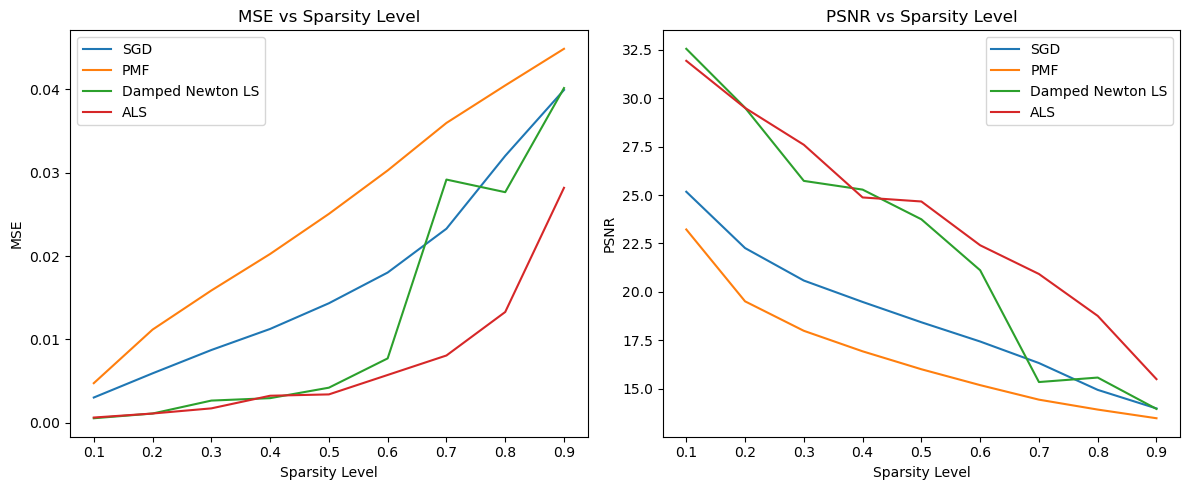

In [31]:
plt.figure(figsize=(12, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(sparsity_levels, mse_sgd, label="SGD")
plt.plot(sparsity_levels, mse_pmf, label="PMF")
plt.plot(sparsity_levels, mse_ntls, label="Damped Newton LS")
plt.plot(sparsity_levels, mse_als, label="ALS")
plt.xlabel("Sparsity Level")
plt.ylabel("MSE")
plt.title("MSE vs Sparsity Level")
plt.legend()

# PSNR Plot
plt.subplot(1, 2, 2)
plt.plot(sparsity_levels, psnr_sgd, label="SGD")
plt.plot(sparsity_levels, psnr_pmf, label="PMF")
plt.plot(sparsity_levels, psnr_ntls, label="Damped Newton LS")
plt.plot(sparsity_levels, psnr_als, label="ALS")
plt.xlabel("Sparsity Level")
plt.ylabel("PSNR")
plt.title("PSNR vs Sparsity Level")
plt.legend()

plt.tight_layout()
plt.show()
